In [46]:
using JLD2
using FourierFlows
using FourierFlows: parsevalsum2
using Printf
using CairoMakie
using AbstractFFTs
include("../../utils/IFMAB3.jl")
include("../../swqg/SWQG.jl")
include("AnalysisUtils.jl")
using .SWQG

In [47]:
# run_directory = "/scratch/nad9961/swqg/60557304/1/"
run_directory = "/scratch/nad9961/swqg/59725734/"
Nsnapshots = count_key_snapshots(run_directory, "qgsw")

16300

In [3]:
diagnostics = jldopen(run_directory * "diagnostics.jld2")
diag_t = diagnostics["diagnostics/kinetic_energy/t"]
KE = diagnostics["diagnostics/kinetic_energy/data"]
PE = diagnostics["diagnostics/potential_energy/data"]
close(diagnostics)
lines(diag_t, KE + PE)

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/OP0XX/src/JLD2.jl:175


LoadError: SystemError: opening file "/scratch/nad9961/swqg/59725734/diagnostics.jld2": No such file or directory

In [10]:
t, qh = load_key_snapshot(run_directory, "swqg", Nsnapshots)

(11293.617f0, ComplexF32[0.0f0 + 0.0f0im 16658.455f0 + 30324.162f0im … 28263.28f0 - 12224.09f0im 16658.445f0 - 30324.158f0im; -24852.121f0 + 37645.1f0im 8271.416f0 + 27418.37f0im … 30072.363f0 + 11908.33f0im 5401.016f0 - 5946.399f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im])

In [5]:
nx = size(qh, 2)
grid = TwoDGrid(; nx=nx, Lx=2π)
Kd2 = read_swqg_params(run_directory, "swqg").Kd2
ν, nν = read_dissipation(run_directory, "swqg")

ψh = @. -qh / (grid.Krsq + Kd2)

uh = @. -1im * grid.l  * ψh
vh = @.  1im * grid.kr * ψh

uxh = @. 1im * grid.kr * uh
vxh = @. 1im * grid.kr * vh
uyh = @. 1im * grid.l  * uh
vyh = @. 1im * grid.l  * vh

q = irfft(qh, grid.nx)
ψ = irfft(ψh, grid.nx)

u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)
ux = irfft(uxh, grid.nx)
vx = irfft(vxh, grid.nx)
uy = irfft(uyh, grid.nx)
vy = irfft(vyh, grid.nx)

ζh = @. 1im * grid.kr * vh - 1im * grid.l * uh
ζ = irfft(ζh, grid.nx)

fig = Figure(size=(600, 300))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,3])
q_max = maximum(abs.(q))
ψ_max = maximum(abs.(ψ))
hm1 = heatmap!(ax1, grid.x, grid.y, q; colormap=:balance, colorrange=(-q_max, q_max))
cbar1 = Colorbar(fig[1,2], hm1)
hm2 = heatmap!(ax2, grid.x, grid.y, ψ; colormap=:balance, colorrange=(-ψ_max, ψ_max))
cbar2 = Colorbar(fig[1,4], hm2)


fig

LoadError: UndefVarError: `qh` not defined

In [30]:
ρ, Ur = FourierFlows.radialspectrum(real.(conj(uh) .* uuxh), grid)
lines(ρ, Ur[:]; axis=(;xscale=log10))

LoadError: UndefVarError: `uuxh` not defined

In [61]:
# run_directory = "/scratch/nad9961/swqg/60557304/1/"
run_directory = "/scratch/nad9961/swqg/59725734/"

#Nsnapshots = count_key_snapshots(run_directory, "swqg")

println(Nsnapshots)
grid = TwoDGrid(; nx=512, Lx=2π, aliased_fraction=1/3)

Kd2 = read_swqg_params(run_directory, "qgsw").Kd2
ν, nν = read_dissipation(run_directory, "qgsw")

Rh = zeros(grid.nkr, grid.nl)
snap_frames = (Nsnapshots-1):Nsnapshots
total_E = zeros(length(snap_frames))
array_idx = 1

#for snap_idx = snap_frames
snap_idx = snap_frames[1]
    if (snap_idx % 10 == 0)
        println(snap_idx)
    end
    t, qh = load_key_snapshot(run_directory, "qgsw", snap_idx)
    dealias!(qh, grid)
    
    ψh = @. -qh / (grid.Krsq + Kd2)

    uh = @. -1im * grid.l  * ψh
    vh = @.  1im * grid.kr * ψh
    
    qxh = @. 1im * grid.kr * qh
    qyh = @. 1im * grid.l  * qh
    
    q = irfft(qh, grid.nx)
    ψ = irfft(ψh, grid.nx)
    
    u = irfft(uh, grid.nx)
    v = irfft(vh, grid.nx)
    qx = irfft(qxh, grid.nx)
    qy = irfft(qyh, grid.nx)
    
    uqxh = rfft(u .* qx)
    vqyh = rfft(v .* qy)

    total_E[array_idx] = (parsevalsum2(uh, grid) + parsevalsum2(vh, grid) + Kd2 * parsevalsum2(ψh, grid))
    array_idx += 1
    
    D = -ν * grid.Krsq.^(nν)
    Eh = @. conj(ψh) * (-uqxh - vqyh)
    Eh += @. ψh * conj(-uqxh - vqyh)
    Rh += real(Eh);
#end

16300


-0.00026465098713134537


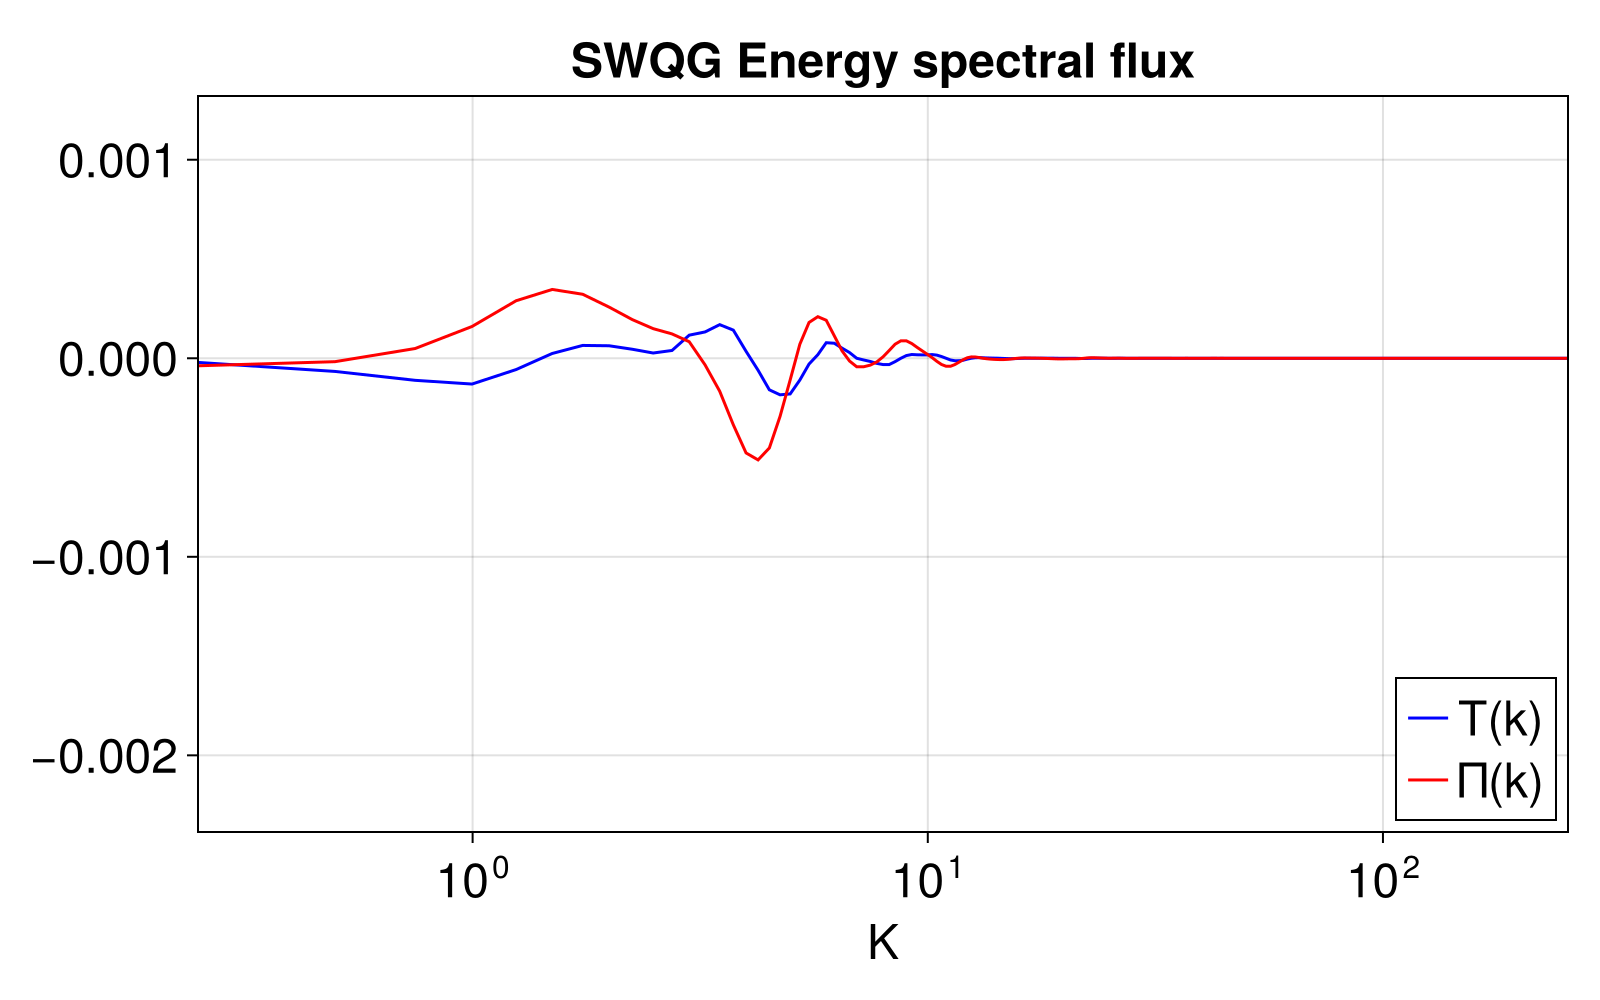

In [63]:
Rh_normed = Rh * grid.Lx * grid.Ly / (grid.nx^2 * grid.ny^2)
ρ, Rhr = FourierFlows.radialspectrum(Rh_normed, grid)
Rhr = Rhr[:]
Πh = cumsum((Rhr)[end:-1:1])[end:-1:1]
Πh2 = -cumsum(Rhr)
fig = Figure(size=(800, 500), fontsize=24)
ax = Axis(fig[1,1]; title = "SWQG Energy spectral flux", xlabel="K",
    xscale=log10, limits=((ρ[2], ρ[end]), (1.1*minimum(ρ.*Πh), 1.1*maximum(ρ.*Πh))))
println(sum(Rh_normed))
lines!(ax, ρ, Rhr, color=:blue, label="T(k)")
lines!(ax, ρ, Πh, color=:red, label="Π(k)")
#lines!(ax, ρ, Πh2, color=:green, label="Π(k)")
axislegend(ax, position=:rb)
fig

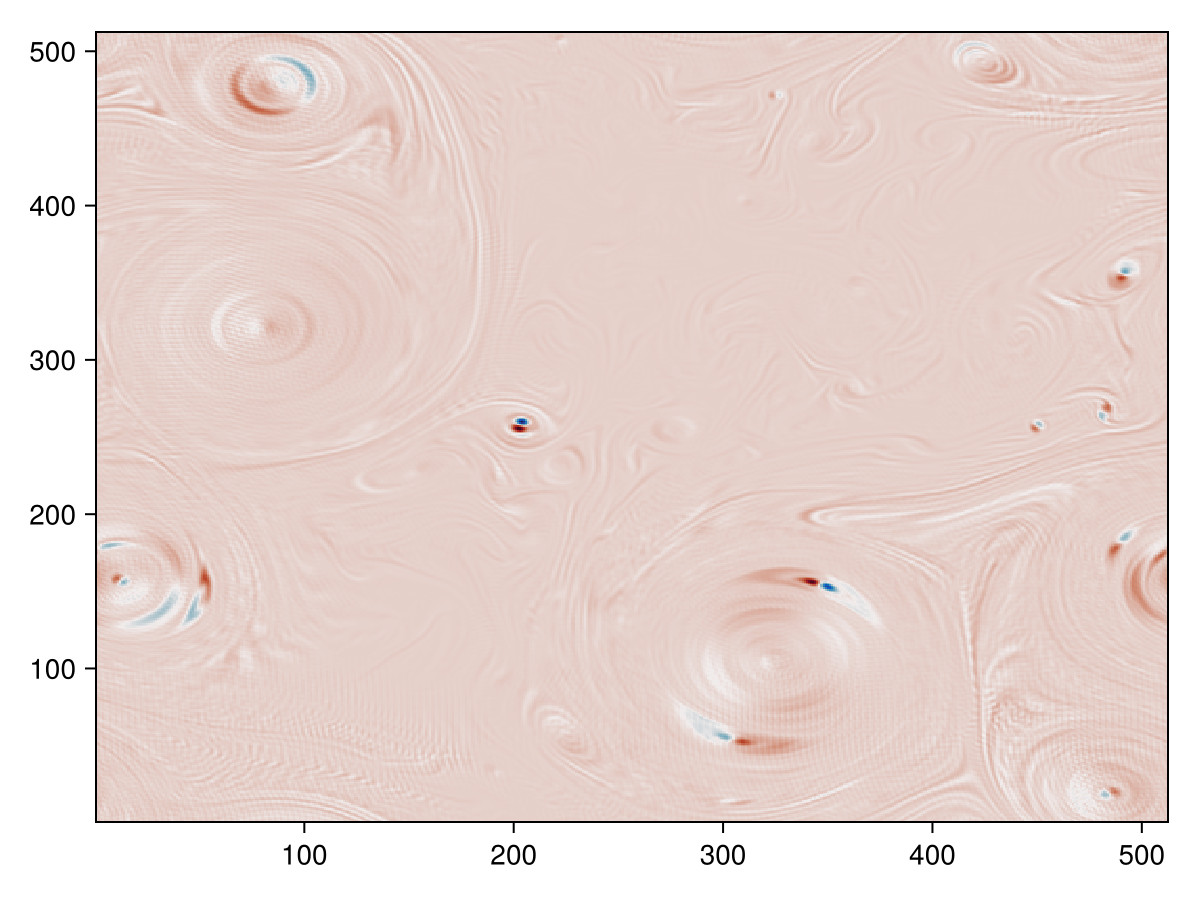

In [42]:
heatmap(u .* qx + v .* qy, colormap=:balance)

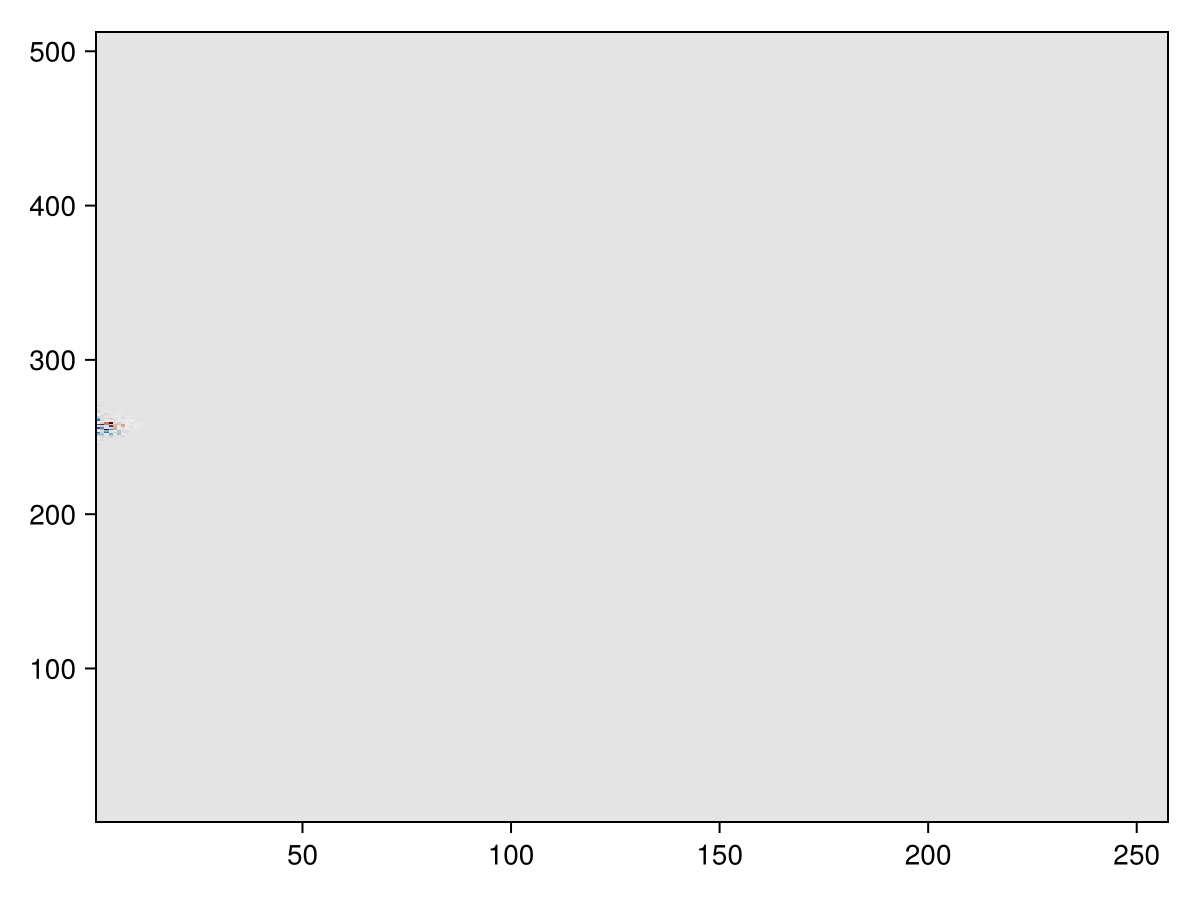

In [45]:
heatmap(fftshift(Rh, 2), colormap=:balance)

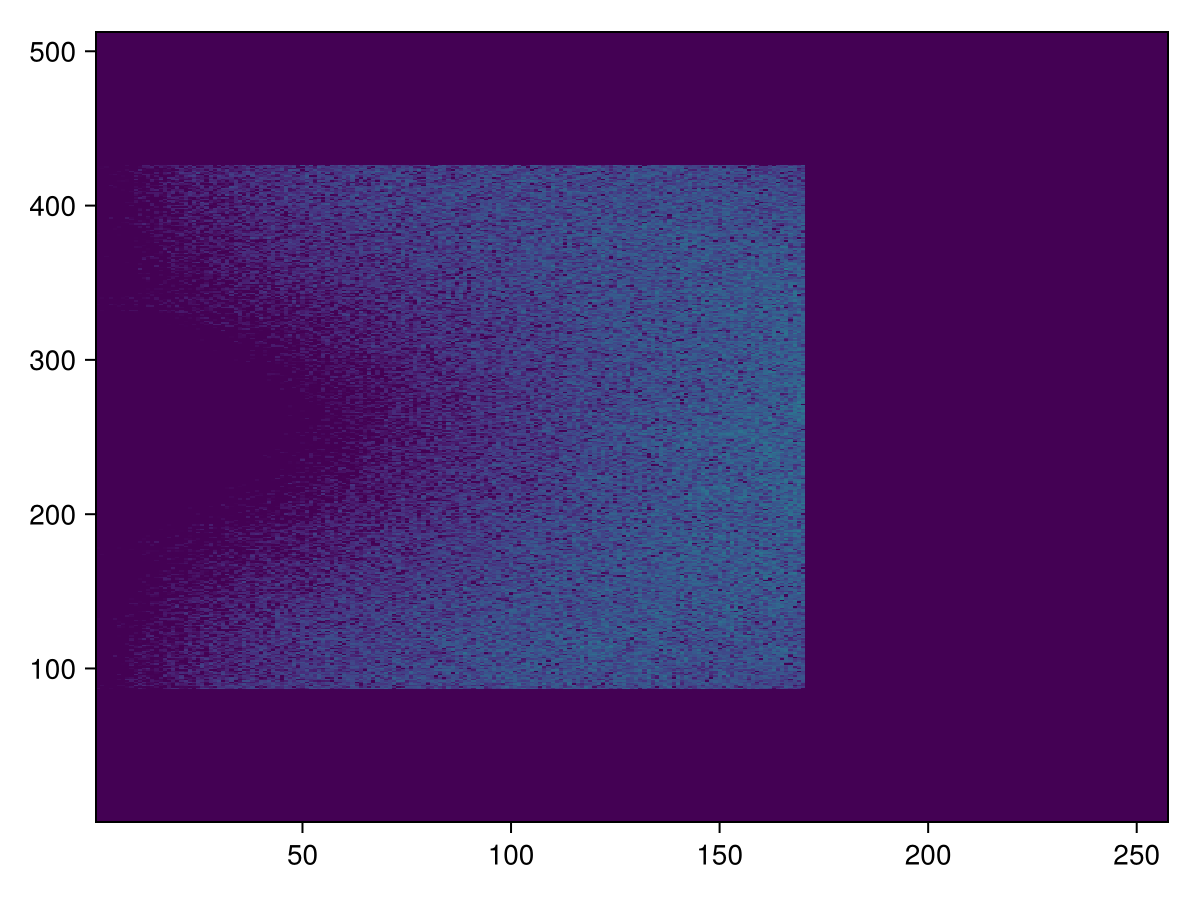

In [201]:
heatmap(fftshift(log.(abs.(conj(uh) .* D .* uh)), 2), colorrange=(-8, 10))

In [255]:
@.  Cg2*conj(ηh)* ηh

257×512 Matrix{ComplexF32}:
 5.47335f5-0.015625im     1.88535f7+0.0im          …  1.94031f7+0.0im
 4.04377f7+0.0im          3.08313f7+1.0im             2.23912f7+0.0im
  8.0061f7-2.0im          7.56946f6-0.125im           8.25725f6+0.0im
 3.46606f6+0.0im          1.41058f7+0.0im             4.62892f6+0.0im
   18400.7+0.0im          1.07795f6-0.0625im          2.61916f6+0.0im
 1.29698f5+0.0im            35541.1+0.000244141im  …  1.44722f5-0.00390625im
   97455.6-0.000976562im    48330.5-0.000488281im       30340.6+0.000976562im
   25854.9+0.0im            24050.3+0.000976562im       4114.87+0.0im
   20069.3+0.0im            499.177+0.0im               13641.5+0.000488281im
   34688.7+0.0im            20096.9+0.0im               26193.7+0.0im
   6016.44-6.10352f-5im     882.978+0.0im          …    6695.43+0.000244141im
   11550.0+0.0im            354.881+0.0im               1203.11+6.10352f-5im
   1615.34+0.0im             6860.1+0.000244141im       5180.87-6.10352f-5im
          ⋮      

In [257]:
@. conj(uh)*uh + conj(vh)*vh

257×512 Matrix{ComplexF32}:
    3332.9+0.0im  2.77009f7+0.0im  …  1.60776f7+0.0im  2.13876f7+0.0im
  4.9716f6+0.0im  1.05521f7+0.0im     2.91236f7+0.0im  4.92364f6+0.0im
 5.91978f7+0.0im  1.00867f7+0.0im     4.05895f7+0.0im  1.30358f7+0.0im
 1.60401f6+0.0im  5.13274f7+0.0im      2.5985f7+0.0im  6.03579f6+0.0im
  6.0704f6+0.0im  7.48957f6+0.0im     3.11153f6+0.0im   1.9178f7+0.0im
  438548.0+0.0im  6.23618f6+0.0im  …  1.24791f6+0.0im  6.18376f5+0.0im
 7.41883f5+0.0im  7.04898f5+0.0im     7.00771f5+0.0im  2.22768f6+0.0im
  3.2403f5+0.0im  1.03762f6+0.0im     2.53454f5+0.0im  4.38392f5+0.0im
   36545.9+0.0im    20906.8+0.0im       56667.5+0.0im  2.85987f5+0.0im
   78137.9+0.0im    5093.15+0.0im       37968.7+0.0im    7992.74+0.0im
   4322.27+0.0im    31348.2+0.0im  …    6321.12+0.0im    13406.1+0.0im
   21785.9+0.0im    14726.3+0.0im       16462.0+0.0im    20589.7+0.0im
   11353.7+0.0im    28856.8+0.0im       12768.2+0.0im    31307.8+0.0im
          ⋮                        ⋱           ⋮ 

In [264]:
conj(ηh) .* ηh

257×512 Matrix{ComplexF32}:
 1.80937f6+0.0im  6.23255f7+0.0im  …  5.58155f7+0.0im  6.41426f7+0.0im
 1.33678f8+0.0im  1.01922f8+0.0im     9.02145f7+0.0im  7.40204f7+0.0im
 2.64664f8+0.0im   2.5023f7+0.0im     7.44174f7+0.0im  2.72967f7+0.0im
 1.14581f7+0.0im  4.66309f7+0.0im     2.18367f7+0.0im  1.53022f7+0.0im
   60828.9+0.0im  3.56346f6+0.0im       38563.9+0.0im  8.65838f6+0.0im
  428753.0+0.0im  1.17491f5+0.0im  …    59930.6+0.0im  4.78421f5+0.0im
 3.22167f5+0.0im   1.5977f5+0.0im     7.78282f5+0.0im  1.00299f5+0.0im
   85470.9+0.0im    79505.0+0.0im     2.61334f5+0.0im    13602.9+0.0im
   66344.6+0.0im    1650.17+0.0im     1.34953f5+0.0im    45096.0+0.0im
 1.14673f5+0.0im    66436.1+0.0im       3043.78+0.0im    86590.8+0.0im
   19889.1+0.0im    2918.93+0.0im  …    66405.4+0.0im    22133.7+0.0im
   38181.7+0.0im    1173.16+0.0im       31627.2+0.0im    3977.23+0.0im
   5339.97+0.0im    22678.0+0.0im       7546.92+0.0im    17126.9+0.0im
          ⋮                        ⋱           ⋮ 

In [270]:
Cg2 * (conj(ηh) .* ηh)

257×512 Matrix{ComplexF32}:
 5.47335f5+0.0im  1.88535f7+0.0im  …  1.68842f7+0.0im  1.94031f7+0.0im
 4.04377f7+0.0im  3.08313f7+0.0im     2.72899f7+0.0im  2.23912f7+0.0im
  8.0061f7+0.0im  7.56946f6+0.0im     2.25113f7+0.0im  8.25725f6+0.0im
 3.46606f6+0.0im  1.41058f7+0.0im     6.60559f6+0.0im  4.62892f6+0.0im
   18400.7+0.0im  1.07795f6+0.0im       11665.6+0.0im  2.61916f6+0.0im
 1.29698f5+0.0im    35541.1+0.0im  …    18129.0+0.0im  1.44722f5+0.0im
   97455.6+0.0im    48330.5+0.0im      2.3543f5+0.0im    30340.6+0.0im
   25854.9+0.0im    24050.3+0.0im       79053.5+0.0im    4114.87+0.0im
   20069.3+0.0im    499.177+0.0im       40823.4+0.0im    13641.5+0.0im
   34688.7+0.0im    20096.9+0.0im       920.744+0.0im    26193.7+0.0im
   6016.44+0.0im    882.978+0.0im  …    20087.6+0.0im    6695.43+0.0im
   11550.0+0.0im    354.881+0.0im       9567.24+0.0im    1203.11+0.0im
   1615.34+0.0im     6860.1+0.0im       2282.94+0.0im    5180.87+0.0im
          ⋮                        ⋱           ⋮ 